# Импортируем библиотеки

In [1]:
import pandas as pd
import re

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#mean_absolute_percentage_error нет в sklearn 0.22, поэтому напишем сами:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import mean_squared_error , max_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor

import xgboost as xgb
import optuna

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session

np.random.seed(42)

# Предобработка данных

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [4]:
df.shape

(377185, 18)

Количество пропущенных значенний:

In [5]:
df.isna().sum() / (df.shape[0])*100 #процент пропусков

status          10.583136
private pool    98.891525
propertyType     9.208479
street           0.000530
baths           28.192532
homeFacts        0.000000
fireplace       72.661956
city             0.009014
schools          0.000000
sqft            10.757851
zipcode          0.000000
beds            24.200856
state            0.000000
stories         39.957846
mls-id          93.387330
PrivatePool     89.312672
MlsId           17.731352
target           0.657767
dtype: float64

Удаляем строки без целевой переменной:

In [6]:
df = df.loc[df['target'].isna() == False]

In [7]:
df.shape

(374704, 18)

Очищаем целевую переменную:

In [8]:
def target_format(target):
    target = re.sub('[^0-9]', '', target) #оставляем только цифры
    target = int(target)
    return target

In [9]:
df['target'] = df['target'].apply(target_format)
df['target'].describe()

count    3.747040e+05
mean     6.447575e+05
std      1.841431e+06
min      1.000000e+00
25%      1.869900e+05
50%      3.200000e+05
75%      5.821000e+05
max      1.950000e+08
Name: target, dtype: float64

Очищаем признаки:

In [10]:
# Преобразовываем в действительные числа
def features_float_format(feature):
    if feature == 0:
        return feature
    feature = re.sub('1 1/2', '1.5', feature) # заменяем 1 1/2 на 1.5 (признак stories)
    feature = re.sub('[^0-9,\.]', '', feature) # оставляем только цифры
    feature = re.sub(',', '.', feature) # заменяем ',' на '.'
    
    try:
        feature = float(feature)
    #если feature - пустая строка, возвращаем 0
    except:
        feature = 0
    return feature
# Преобразовываем статус
def status_format(status):
    status = status.lower()
    # если дом ещё не сделан,оставляем только 'coming soon', дату удаляем
    if status.startswith('coming soon'): 
        status = 'coming soon'
        
    status = re.sub('[^a-z]', ' ', status) # оставляем только буквы
    status = re.sub(r'\b\w{,2}\b', '', status) # удаляем сочетание из 1 и 2 букв
    status = re.sub(r'\s+', '', status) # заменяем 1 или более пробелов на ''
    if status == 'active' or status == 'for sale': # бóльшая часть домов - for sale или active
        status = 1
    else:
        status = 0
    return status
#Преобразовываем фичу камина
def fireplace_format(fireplace):
    if fireplace == 0:
        return fireplace
    fireplace = fireplace.lower()
    
    if fireplace.count('no')>0:
        fireplace = 0
    else:
        fireplace = 1
    return fireplace

In [11]:
dummy_features = ['status','state']  
drop_features = ['street', 'mls-id', 'MlsId', 'schools', 'homeFacts', 'city', 'zipcode'] 

#### Status

In [12]:
df.status.value_counts()

for sale                     156100
Active                       105206
For sale                      43465
foreclosure                    5677
New construction               5459
                              ...  
Pending Take Backups              1
Contingent - Sale of Home         1
Under Contract W/ Bckp            1
Coming soon: Dec 15.              1
Coming soon: Dec 27.              1
Name: status, Length: 156, dtype: int64

Приблизительно 80% домов - ```for sale``` или ```for sale```, поэтому вместо них ставим ```1```, иначе ```0```
(заполняем пропуски на пустые строки, и применяем ```status_format```):

In [13]:
df['status'] = df['status'].fillna('')
df['status'] = df['status'].apply(status_format)

#### Property Type

In [14]:
df.propertyType.value_counts()

single-family home                                                   91376
Single Family                                                        61888
Single Family Home                                                   31725
condo                                                                25878
lot/land                                                             20532
                                                                     ...  
Spanish, Split Level                                                     1
Cape, Cottage                                                            1
Architectural                                                            1
Contemporary, Spanish, Santa Barbara/Tuscan, Territorial/Santa Fe        1
Condominium (3+ Levels), Modern                                          1
Name: propertyType, Length: 1279, dtype: int64

Приблизительно 50% домов - ```single family```, поэтому оставляем только этот признак:

In [15]:
def propertyType_format(propertyType):
    propertyType = propertyType.lower()
    propertyType = re.sub('[^a-z]', ' ', propertyType)# оставляем только буквы
    
    # если начинается на 'single family' - ставим 1, иначе 0
    if propertyType.startswith('single family'): 
        propertyType = 1 
    else:
        propertyType = 0
    return propertyType

In [16]:
df['propertyType'] = df['propertyType'].fillna('')
df['propertyType'] = df['propertyType'].apply(propertyType_format)

#### Private pool
Вместо пропусков ставим ```no```, заполняем вместо ```yes``` - 1, вместо ```no``` - 0

In [17]:
df['private pool'] = df['private pool'].fillna('no')
df['private pool'] = df['private pool'].apply(lambda pool: 1 if pool.lower() == 'yes' else 0)

df['PrivatePool'] = df['PrivatePool'].fillna('no')
df['PrivatePool'] = df['PrivatePool'].apply(lambda pool: 1 if pool.lower() == 'yes' else 0)

df['PrivatePool'] = df['private pool'] | df['PrivatePool']
df.drop(['private pool'], axis=1, inplace=True)

#### Baths, sqft, beds, stories, fireplace
Заполняем пропуски нулями
К ```Baths, sqft, beds, stories``` применяем ```features_float_format```, а к ```fireplace``` - ```fireplace_format```:

In [18]:
df['baths'] = df['baths'].fillna(0)
df['baths'] = df['baths'].apply(features_float_format)

df['sqft'] = df['sqft'].fillna(0)
df['sqft'] = df['sqft'].apply(features_float_format)

df['beds'] = df['beds'].fillna(0)
df['beds'] = df['beds'].apply(features_float_format)

df['stories'] = df['stories'].fillna(0)
df['stories'] = df['stories'].apply(features_float_format)

df['fireplace'] = df['fireplace'].fillna(0)
df['fireplace'] = df['fireplace'].apply(fireplace_format)

#### Year Built

In [19]:
df['homeFacts'] = df['homeFacts'].apply(eval) # конвертируем строку в словарь, используя eval

Нужное нам значение хранится в первом словаре, который хранится в списке, который, в свою очередь, хранится в словаре с ключом ```atAGlanceFacts```:

In [20]:
M = df['homeFacts'][0]
print(M,'\n')
print(M['atAGlanceFacts'],'\n')
print(M['atAGlanceFacts'][0],'\n')
print(M['atAGlanceFacts'][0]['factValue'],'\n')

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]} 

[{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}] 

{'factValue': '2019', 'factLabel': 'Year built'} 

2019 



In [21]:
def homeFacts_format(homeFacts):
    # если homeFacts - непустой словарь, берём значение 'atAGlanceFacts', иначе 0
    homeFacts = homeFacts.get('atAGlanceFacts', 0) 
    if homeFacts == 0: 
        return 0
    # берём первый елемент списка
    homeFacts = homeFacts[0]
    # если словарь не пуст, то берем значение
    if homeFacts.get('factLabel') == 'Year built':
        homeFacts = homeFacts.get('factValue')
    # если homeFacts - число, то выводим его, иначе 0
    try:
        homeFacts = int(homeFacts)
    except:
        homeFacts = 0
    return homeFacts

In [22]:
df['yearBuilt'] = df['homeFacts'].apply(homeFacts_format)

#### Schools rating

In [23]:
df['schools'] = df['schools'].apply(eval) # конвертируем строку в словарь, используя eval

Список с рейтингами школ хранится в словаре, который хранится в списке:

In [24]:
M = df['schools'][0]
print(M,'\n')
print(M[0],'\n')
print(M[0]['rating'])

[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']}] 

{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']} 

['4', '4', '

In [25]:
def rating_format(schools):
    # если schools - непустой словарь, берём значение 'rating', иначе 0
    schools = schools[0]
    schools = schools.get('rating', 0)
    if schools == 0: 
        return 0
    
    rating = []
    for x in schools:
        x = re.sub('/10','',x) # если рейтинг записан в формате 'x/10', заменяем на 'x'
        rating.append(features_float_format(x)) # с помощью features_float_format превращаем x в число
    # ищем среднее арифметическое рейтингов
    return np.mean(rating)

Применяем ```rating_format```, если результат - ```nan```, заменяем на ```0```:

In [26]:
df['rating'] = df['schools'].apply(rating_format)
df['rating'] = df['rating'].fillna(0)

C:\Users\andru\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.



#### Distance
По аналогии с ```rating```, выбираем значение из списка словарей и ищем среднее арифметическое расстояний

In [27]:
def distance_format(schools):
    # если schools - непустой словарь, берём значение 'data', иначе 0
    schools = schools[0]
    schools = schools.get('data', 0)
    if schools == 0: 
        return 0
    # если schools - непустой словарь, берём значение 'distance', иначе 0
    schools = schools.get('Distance', 0)
    if schools == 0: 
        return 0
    
    distance=[]
    for x in schools:
        distance.append(features_float_format(x)) # с помощью features_float_format превращаем x в число
    # ищем среднее арифметическое расстояний
    return np.mean(distance)

Применяем ```distance_format``` и заполняем пропуски нулями:

In [28]:
df['distance'] = df['schools'].apply(distance_format)
df['distance'] = df['distance'].fillna(0)

Удаляем ненужные фичи:

In [29]:
df.drop(drop_features, axis=1, inplace=True)

#### State 
Штаты - dummy-features, поэтому применяем к ```df['state']``` функцию ```pd.get_dummies``` ,и конкатенируем результат к датасету:

In [30]:
df = pd.concat([df, pd.get_dummies(df['state'])], axis=1)
df.drop('state', axis=1, inplace=True)

##### Итог:
Мы предобработали и очистили данные, и получили 8 числовых и 43 dummy признака.

# Статистический анализ

In [31]:
df.head()

,status,propertyType,baths,fireplace,sqft,beds,stories,PrivatePool,target,yearBuilt,...,OT,PA,SC,TN,TX,UT,VA,VT,WA,WI
0,1,1,3.5,1,2900.000,4.0,0.0,0,418000,2019,...,0,0,0,0,0,0,0,0,0,0
1,0,1,3.0,0,1.947,3.0,2.0,0,310000,2019,...,0,0,0,0,0,0,0,0,1,0
2,0,1,2.0,1,3.000,3.0,1.0,1,2895000,1961,...,0,0,0,0,0,0,0,0,0,0
3,0,1,8.0,1,6.457,5.0,3.0,0,2395000,2006,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0.0,0,0.000,0.0,0.0,0,5000,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df.describe(include='all')

,status,propertyType,baths,fireplace,sqft,beds,stories,PrivatePool,target,yearBuilt,...,OT,PA,SC,TN,TX,UT,VA,VT,WA,WI
count,374704.000000,374704.000000,3.747040e+05,374704.000000,3.747040e+05,374704.000000,374704.000000,374704.000000,3.747040e+05,3.747040e+05,...,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000
mean,0.281953,0.493694,3.718902e+02,0.267360,1.515056e+03,2.417060,1.101108,0.118152,6.447575e+05,2.990621e+06,...,0.000003,0.014705,0.000075,0.048654,0.222464,0.003525,0.002135,0.002306,0.036666,0.001206
std,0.449951,0.499961,1.928389e+05,0.442583,7.459239e+05,3.936648,3.432640,0.322788,1.841431e+06,1.293752e+09,...,0.001634,0.120369,0.008644,0.215145,0.415901,0.059271,0.046157,0.047964,0.187941,0.034711
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000,1.302000e+00,0.000000,0.000000,0.000000,1.869900e+05,1.926000e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,2.000000e+00,0.000000,2.069000e+00,3.000000,1.000000,0.000000,3.200000e+05,1.974000e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,3.000000e+00,1.000000,4.018000e+00,4.000000,2.000000,0.000000,5.821000e+05,2.005000e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.161161e+08,1.000000,4.566025e+08,871.000000,1120.000000,1.000000,1.950000e+08,5.599906e+11,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Построим матрицу корреляций:

In [33]:
corr = df.corr()

cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "5pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "8pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '8pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("correlation matrix")\
    .set_precision(2)\
    .set_table_styles(magnify())

Избыточной кореляции между признаками нету, значит никаких признаков удалять ненужно. 
Построим гистограмы с различными признаками:

Построим гистограмму логарифма целевой переменной:

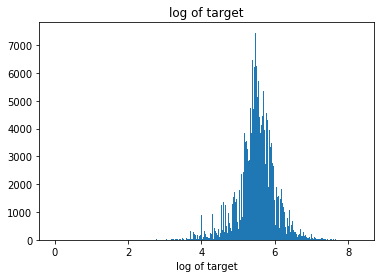

In [34]:
_ = plt.hist(np.log10(df['target']),bins = 'auto')
plt.title('log of target')
plt.xlabel('log of target')
plt.show()

Отсюда видно, что существует пик в точке 5.5, а распределение - нормальное.

Построим гистограмму логарифма площади, если площадь не равна ```0```:

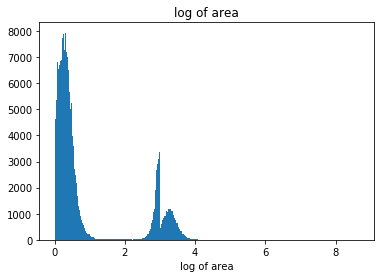

In [35]:
_ = plt.hist(np.log10(df[df['sqft']>0]['sqft']),bins = 'auto')
plt.title('log of area')
plt.xlabel('log of area')
plt.show()

Видно 3 пика: на 0.5 и 2 пика поменьше около 2.5. Значит, много значенний площади меньше $10^1$= ```10 кв. фт.```, а оставшиеся находятся на промежутке от около ```1000``` до ```10000```:

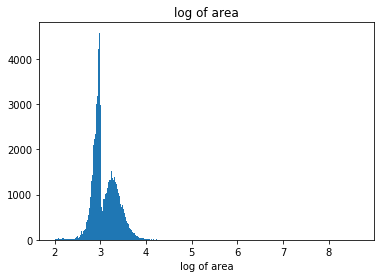

In [36]:
_ = plt.hist(np.log10(df[df['sqft']>100]['sqft']),bins = 'auto')
plt.title('log of area')
plt.xlabel('log of area')
plt.show()

Построим гистограмму распределений кроватей, убрав объекты, где количество кроватей меньше ```15```:

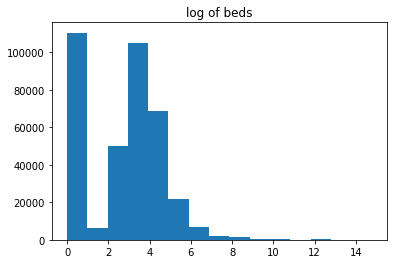

In [37]:
_ = plt.hist(df[df['beds']<15]['beds'],bins = 15)
plt.title('log of beds')
plt.show()

Построим гистограмму распределений этажей, убрав объекты, где количество этажей меньше 16:

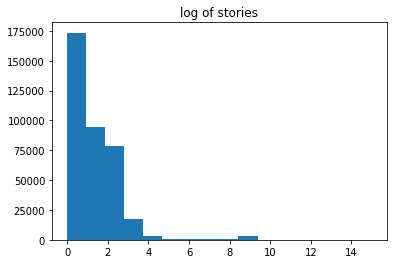

In [38]:
_ = plt.hist(df[df['stories']<16]['stories'],bins = 16)
plt.title('log of stories')
plt.show()

Построим гистограмму распределений рейтинга школ, убрав объекты:

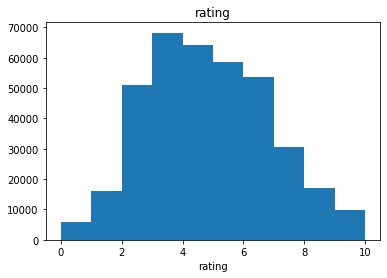

In [39]:
_ = plt.hist(df['rating'],bins = 10)
plt.title('rating')
plt.xlabel('rating')
plt.show()

Построим гистограмму логарифма расстояний:

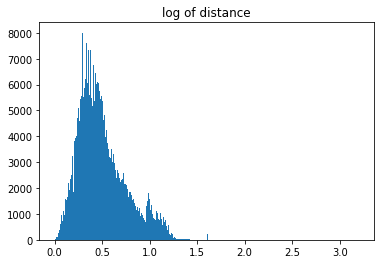

In [40]:
_ = plt.hist(np.log10(df['distance']+1),bins = 'auto')
plt.title('log of distance')
plt.show()

Построим гистограмму распределений ванных, убрав объекты, где количество ванных меньше 20:

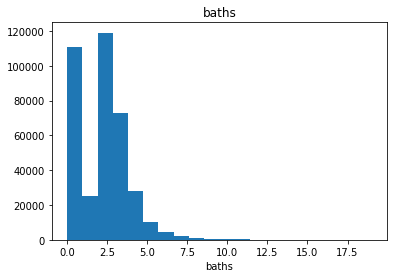

In [41]:
_ = plt.hist(df[df['baths']<20]['baths'],bins = 20)
plt.title('baths')
plt.xlabel('baths')
plt.show()

Построим гистограмму распределений года постройки, убрав шумы(меньше 1875 или больше 2020):

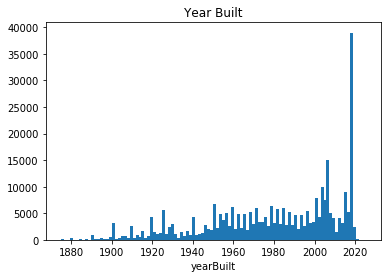

In [42]:
_ = plt.hist(df.loc[(df['yearBuilt'] >= 1875) & (df['yearBuilt'] <= 2100)]['yearBuilt'],bins = 'auto')
plt.title('Year Built')
plt.xlabel('yearBuilt')
plt.show()

###### Точечные диаграммы целевой переменной и признаков

Построим точечную диаграмму целевой переменной и рейтинга школ:

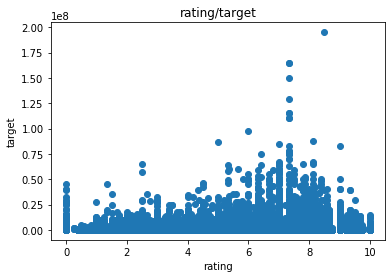

In [43]:
_ = plt.scatter(df['rating'],df['target'])

plt.title('rating/target')
plt.xlabel('rating')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму целевой переменной и расстояний до школ:

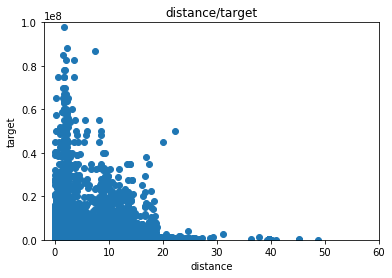

In [44]:
_ = plt.scatter(df['distance'],df['target'])
# Ограничим график по осям, чтобы рассмотреть данные без шумов
plt.xlim(-2,60)
plt.ylim(-100,1e8)

plt.title('distance/target')
plt.xlabel('distance')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму целевой переменной и количества этажей:

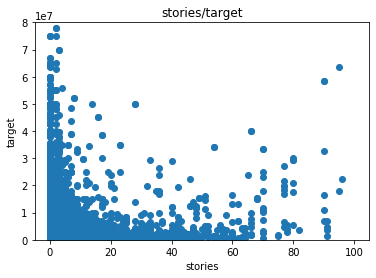

In [45]:
_ = plt.scatter(df['stories'],df['target'])
# Ограничим график по осям, чтобы рассмотреть данные без шумов
plt.xlim(-5,105)
plt.ylim(-10,1e7*8)

plt.title('stories/target')
plt.xlabel('stories')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму целевой переменной и количества кроватей:

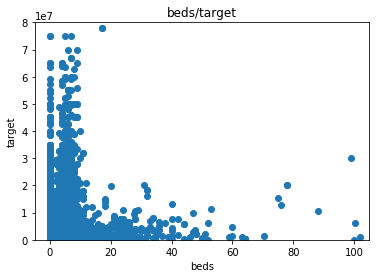

In [46]:
_ = plt.scatter(df['beds'],df['target'])
# Ограничим график по осям, чтобы рассмотреть данные без шумов
plt.xlim(-5,105)
plt.ylim(-10,1e7*8)

plt.title('beds/target')
plt.xlabel('beds')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму целевой переменной и года постройки:

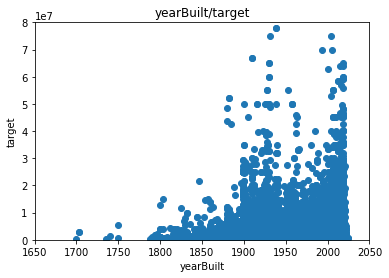

In [47]:
_ = plt.scatter(df['yearBuilt'],df['target'])
# Ограничим график по осям, чтобы рассмотреть данные без шумов
plt.xlim(1650,2050)
plt.ylim(-50,8*1e7)

plt.title('yearBuilt/target')
plt.xlabel('yearBuilt')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму целевой переменной и площади:

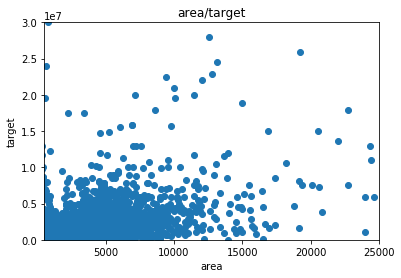

In [48]:
_ = plt.scatter(df['sqft'],df['target'])
# Ограничим график по осям, чтобы рассмотреть данные без шумов
plt.xlim(500,0.25*1e5)
plt.ylim(-1000,3*1e7)

plt.title('area/target')
plt.xlabel('area')
plt.ylabel('target')

plt.show()

# Построение моделей

Разобьем данные на обучающаю и тестовую выборки:

In [49]:
X, y = df.drop('target', axis = 1), df['target']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((299763, 50), (299763,), (74941, 50), (74941,))

Сделаем функцию для оценки точности предсказаний:

In [52]:
def evaluate(clf, X_train, y_train, X_test, y_test):
    #делаем предсказание
    train_predict = clf.predict(X_train)
    test_predict = clf.predict(X_test)
    #mse
    print('train mse :', mean_squared_error(y_train, train_predict) )
    print('test mse  :', mean_squared_error(y_test, test_predict) )
    #max error
    print('train max error :', max_error(y_train, train_predict) )
    print('test max error  :', max_error(y_test, test_predict) )
    #MAE
    print('train mean absolute error :', mean_absolute_error(y_train, train_predict) )
    print('test mean absolute error  :', mean_absolute_error(y_test, test_predict) )
    #MAPE
    print('train mean absolute percentage error :', mean_absolute_percentage_error(y_train, train_predict) )
    print('test mean percentage error  :', mean_absolute_percentage_error(y_test, test_predict) )
    #RMSE
    print('train rmse :', np.sqrt(mean_squared_error(y_train, train_predict) ))
    print('test rmse  :',np.sqrt(mean_squared_error(y_test, test_predict) ))
    #Coefficient of determination
    print('train R^2', clf.score(X_train,y_train)) 
    print('test R^2', clf.score(X_test,y_test))

### Линейная регрессия

In [53]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [54]:
evaluate(lr,X_train, y_train, X_test, y_test)

train mse : 3219381212888.361
test mse  : 2664242940164.8345
train max error : 192441482.88671485
test max error  : 162244727.42354852
train mean absolute error : 532890.829417128
test mean absolute error  : 516901.9289499894
train mean absolute percentage error : 1685.9078327188904
test mean percentage error  : 2060.557591486262
train rmse : 1794263.4179206688
test rmse  : 1632250.8815022386
train R^2 0.08283381374268073
test R^2 0.08557162389263684


Коэффициент детерминации ниже 0.1, а значит модель очень плохо предсказывает результат. Попробуем различные деревья решений:

### Деревья решений

С помощью ```optune``` переберём различные варианты ```max_depth```:

In [55]:
def objective(trial):
    tree_max_depth = trial.suggest_int('tree_max_depth', 5, 10)
    
    tree = DecisionTreeRegressor(max_depth  = tree_max_depth, random_state = 42)
    tree.fit(X_train,y_train)

    test_predict = tree.predict(X_test)

    return mean_squared_error(y_test, test_predict)

study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 7)

[I 2020-09-24 19:20:28,838] A new study created in memory with name: no-name-f77b2a98-e43e-4fb0-8855-d0d685fe51b2
[I 2020-09-24 19:20:30,663] Trial 0 finished with value: 1631856175914.3977 and parameters: {'tree_max_depth': 8}. Best is trial 0 with value: 1631856175914.3977.
[I 2020-09-24 19:20:32,241] Trial 1 finished with value: 1526524548885.7373 and parameters: {'tree_max_depth': 7}. Best is trial 1 with value: 1526524548885.7373.
[I 2020-09-24 19:20:33,424] Trial 2 finished with value: 1647617899831.2554 and parameters: {'tree_max_depth': 6}. Best is trial 1 with value: 1526524548885.7373.
[I 2020-09-24 19:20:34,873] Trial 3 finished with value: 1526524548885.7373 and parameters: {'tree_max_depth': 7}. Best is trial 1 with value: 1526524548885.7373.
[I 2020-09-24 19:20:36,487] Trial 4 finished with value: 1526524548885.7373 and parameters: {'tree_max_depth': 7}. Best is trial 1 with value: 1526524548885.7373.
[I 2020-09-24 19:20:38,439] Trial 5 finished with value: 1631856175914.

Итог: при максимальной глубине меньше 7 модель недообучается, а при максимальной глубине больше 7 - переобучается. 

In [56]:
tree = DecisionTreeRegressor(max_depth  = 7 ,random_state = 42)
tree.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=7, random_state=42)

In [57]:
evaluate(tree,X_train, y_train, X_test, y_test)

train mse : 1704901631539.0444
test mse  : 1526524548885.7373
train max error : 149186860.32494673
test max error  : 74186860.32494673
train mean absolute error : 392195.28523315105
test mean absolute error  : 391135.5533402253
train mean absolute percentage error : 1725.6092033495565
test mean percentage error  : 1952.2499940912599
train rmse : 1305718.8179462852
test rmse  : 1235526.0211285464
train R^2 0.5142923363401106
test R^2 0.47606228272889894


### Попробуем различные ансамбли:

С помощью ```optune``` переберём различные варианты ```n_estimators```:

In [58]:
def objective(trial):
    bagging_n_estimators = trial.suggest_int("rf_n_estimators", 5, 19)
    
    bagging_trees = BaggingRegressor(tree, n_estimators = bagging_n_estimators)
    bagging_trees.fit(X_train,y_train)

    test_predict = bagging_trees.predict(X_test)

    return mean_squared_error(y_test, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 7)

[I 2020-09-24 19:20:42,017] A new study created in memory with name: no-name-3f0cc8d9-bf0c-46f5-b185-79b4a3f1fdc3
[I 2020-09-24 19:20:47,959] Trial 0 finished with value: 1480779103398.9238 and parameters: {'rf_n_estimators': 5}. Best is trial 0 with value: 1480779103398.9238.
[I 2020-09-24 19:21:03,575] Trial 1 finished with value: 1443354166087.6367 and parameters: {'rf_n_estimators': 13}. Best is trial 1 with value: 1443354166087.6367.
[I 2020-09-24 19:21:25,379] Trial 2 finished with value: 1429259420528.2188 and parameters: {'rf_n_estimators': 19}. Best is trial 2 with value: 1429259420528.2188.
[I 2020-09-24 19:21:35,399] Trial 3 finished with value: 1510740163831.3325 and parameters: {'rf_n_estimators': 9}. Best is trial 2 with value: 1429259420528.2188.
[I 2020-09-24 19:21:46,840] Trial 4 finished with value: 1443344945595.9558 and parameters: {'rf_n_estimators': 10}. Best is trial 2 with value: 1429259420528.2188.
[I 2020-09-24 19:21:54,404] Trial 5 finished with value: 151497

In [59]:
bagging_trees = BaggingRegressor(tree, n_estimators = 19)
bagging_trees.fit(X_train,y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=7,
                                                      random_state=42),
                 n_estimators=19)

In [60]:
evaluate(bagging_trees,X_train, y_train, X_test, y_test)

train mse : 1605440530445.4153
test mse  : 1437776986702.8699
train max error : 148965490.85587826
test max error  : 73965490.85587828
train mean absolute error : 382578.24873865396
test mean absolute error  : 381391.2017744201
train mean absolute percentage error : 1740.5066105402354
test mean percentage error  : 1797.3168642604676
train rmse : 1267059.7975018446
test rmse  : 1199073.386704446
train R^2 0.5426277066298424
test R^2 0.5065224513370011


С помощью ```optune``` переберём различные варианты ```n_estimators``` и  ```max_depth```:

In [61]:
def objective(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 5, 10)
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 8, 13)
    
    random_forest = RandomForestRegressor(n_estimators = rf_n_estimators, max_depth = rf_max_depth, random_state = 42)
    random_forest.fit(X_train,y_train)

    test_predict = random_forest.predict(X_test)

    return mean_squared_error(y_test, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 8)

[I 2020-09-24 19:22:37,609] A new study created in memory with name: no-name-56007901-7492-4d85-9027-5325f1fad85d
[I 2020-09-24 19:22:46,775] Trial 0 finished with value: 1382025770736.0771 and parameters: {'rf_max_depth': 8, 'rf_n_estimators': 8}. Best is trial 0 with value: 1382025770736.0771.
[I 2020-09-24 19:22:53,384] Trial 1 finished with value: 1836639705969.2085 and parameters: {'rf_max_depth': 5, 'rf_n_estimators': 9}. Best is trial 0 with value: 1382025770736.0771.
[I 2020-09-24 19:23:00,341] Trial 2 finished with value: 1608671899288.568 and parameters: {'rf_max_depth': 6, 'rf_n_estimators': 8}. Best is trial 0 with value: 1382025770736.0771.
[I 2020-09-24 19:23:07,166] Trial 3 finished with value: 1836639705969.2085 and parameters: {'rf_max_depth': 5, 'rf_n_estimators': 9}. Best is trial 0 with value: 1382025770736.0771.
[I 2020-09-24 19:23:15,239] Trial 4 finished with value: 1581369736276.3293 and parameters: {'rf_max_depth': 6, 'rf_n_estimators': 9}. Best is trial 0 with

In [62]:
random_forest = RandomForestRegressor(n_estimators = 13, max_depth = 10, random_state = 42)
random_forest.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, n_estimators=13, random_state=42)

In [63]:
evaluate(random_forest,X_train, y_train, X_test, y_test)

train mse : 1080894169707.8655
test mse  : 1272904718819.0222
train max error : 107590579.75029305
test max error  : 72471864.76542161
train mean absolute error : 328835.89655345934
test mean absolute error  : 343175.9852412356
train mean absolute percentage error : 1501.2708589774263
test mean percentage error  : 1794.7893928963922
train rmse : 1039660.6031334772
test rmse  : 1128230.7914691134
train R^2 0.6920651771806459
test R^2 0.5631103389929359


С помощью ```optune``` переберём различные варианты ```n_estimators``` :

In [64]:
def objective(trial):
    ada_n_estimators = trial.suggest_int("ada_n_estimators", 5, 10)
    
    adaboost = AdaBoostRegressor(tree,n_estimators = ada_n_estimators, random_state = 42)
    adaboost.fit(X_train,y_train)

    test_predict = adaboost.predict(X_test)

    return mean_squared_error(y_test, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 6)

[I 2020-09-24 19:24:08,197] A new study created in memory with name: no-name-11d65258-d8b0-4eba-a43e-7286536ed7c5
[I 2020-09-24 19:24:30,705] Trial 0 finished with value: 1881562668042.0168 and parameters: {'ada_n_estimators': 10}. Best is trial 0 with value: 1881562668042.0168.
[I 2020-09-24 19:24:43,176] Trial 1 finished with value: 1667680105422.713 and parameters: {'ada_n_estimators': 5}. Best is trial 1 with value: 1667680105422.713.
[I 2020-09-24 19:25:02,111] Trial 2 finished with value: 1895092126740.703 and parameters: {'ada_n_estimators': 8}. Best is trial 1 with value: 1667680105422.713.
[I 2020-09-24 19:25:21,012] Trial 3 finished with value: 1895092126740.703 and parameters: {'ada_n_estimators': 8}. Best is trial 1 with value: 1667680105422.713.
[I 2020-09-24 19:25:37,094] Trial 4 finished with value: 1614448511912.7925 and parameters: {'ada_n_estimators': 6}. Best is trial 4 with value: 1614448511912.7925.
[I 2020-09-24 19:25:51,936] Trial 5 finished with value: 161444851

In [65]:
adaboost = AdaBoostRegressor(tree,n_estimators = 6, random_state = 42)
adaboost.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=7,
                                                       random_state=42),
                  n_estimators=6, random_state=42)

In [66]:
evaluate(adaboost,X_train, y_train, X_test, y_test)

train mse : 1553011111029.137
test mse  : 1614448511912.7925
train max error : 63276393.40322581
test max error  : 73694544.3843318
train mean absolute error : 434904.90564506664
test mean absolute error  : 435041.7885530999
train mean absolute percentage error : 2187.612347538615
test mean percentage error  : 2304.984005326077
train rmse : 1246198.664350567
test rmse  : 1270609.504101395
train R^2 0.5575642697374376
test R^2 0.44588479196044095


С помощью ```optune``` переберём различные варианты ```n_estimators, max_depth, min_samples_split```:

In [67]:
def objective(trial):
    gb_max_depth = trial.suggest_int('gb_max_depth', 5, 10)
    gb_n_estimators = trial.suggest_int('gb_n_estimators', 8, 20)
    gb_min_samples_split = trial.suggest_int('gb_min_samples_split', 2, 5)
    
    gradientboosting = GradientBoostingRegressor(n_estimators = gb_n_estimators, 
                                                 max_depth = gb_max_depth,
                                                 min_samples_split = gb_min_samples_split,
                                                 loss = 'ls')

    gradientboosting.fit(X_train, y_train)
    test_predict = gradientboosting.predict(X_test)

    return mean_squared_error(y_test, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-09-24 19:26:08,326] A new study created in memory with name: no-name-0908bb17-59c0-4084-923b-63a221569e36
[I 2020-09-24 19:26:28,013] Trial 0 finished with value: 1461836878447.6462 and parameters: {'gb_max_depth': 9, 'gb_n_estimators': 10, 'gb_min_samples_split': 2}. Best is trial 0 with value: 1461836878447.6462.
[I 2020-09-24 19:26:52,712] Trial 1 finished with value: 1388657555836.891 and parameters: {'gb_max_depth': 6, 'gb_n_estimators': 19, 'gb_min_samples_split': 3}. Best is trial 1 with value: 1388657555836.891.
[I 2020-09-24 19:27:16,100] Trial 2 finished with value: 1423304185640.9673 and parameters: {'gb_max_depth': 9, 'gb_n_estimators': 12, 'gb_min_samples_split': 5}. Best is trial 1 with value: 1388657555836.891.
[I 2020-09-24 19:27:32,117] Trial 3 finished with value: 1666226789343.491 and parameters: {'gb_max_depth': 5, 'gb_n_estimators': 15, 'gb_min_samples_split': 2}. Best is trial 1 with value: 1388657555836.891.
[I 2020-09-24 19:27:42,691] Trial 4 finished wi

In [68]:
gradientboosting = GradientBoostingRegressor(n_estimators = 20, max_depth = 12, min_samples_split = 4,loss = 'ls')
gradientboosting.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=12, min_samples_split=4, n_estimators=20)

In [69]:
evaluate(gradientboosting,X_train, y_train, X_test, y_test)

train mse : 669318181223.7843
test mse  : 1233708459333.5425
train max error : 80817470.37540305
test max error  : 73240778.94478846
train mean absolute error : 269310.9871666372
test mean absolute error  : 306650.358607564
train mean absolute percentage error : 1630.108138654539
test mean percentage error  : 2062.6595679090324
train rmse : 818118.6840696064
test rmse  : 1110724.2949236063
train R^2 0.80931863514388
test R^2 0.5765633808948026


#### XGBoost

С помощью ```optune``` переберём различные варианты ```n_estimators, max_depth```:

In [70]:
def objective(trial):
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 5, 10)
    xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 8, 125)
    model = xgb.XGBRegressor(max_depth = xgb_max_depth, 
                                 n_estimators = xgb_n_estimators,
                                 seed = 42) 

    model.fit(X_train, y_train)
    test_predict = model.predict(X_test)

    return mean_squared_error(y_test, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-09-24 19:31:51,715] A new study created in memory with name: no-name-61718e2c-b00d-4d57-8cb7-77327280aa3c
[I 2020-09-24 19:32:19,536] Trial 0 finished with value: 1225467593387.193 and parameters: {'xgb_max_depth': 10, 'xgb_n_estimators': 119}. Best is trial 0 with value: 1225467593387.193.
[I 2020-09-24 19:32:38,728] Trial 1 finished with value: 1126892440399.4854 and parameters: {'xgb_max_depth': 7, 'xgb_n_estimators': 124}. Best is trial 1 with value: 1126892440399.4854.
[I 2020-09-24 19:32:41,379] Trial 2 finished with value: 1258591533280.147 and parameters: {'xgb_max_depth': 10, 'xgb_n_estimators': 8}. Best is trial 1 with value: 1126892440399.4854.
[I 2020-09-24 19:32:50,690] Trial 3 finished with value: 1136448107680.4148 and parameters: {'xgb_max_depth': 5, 'xgb_n_estimators': 79}. Best is trial 1 with value: 1126892440399.4854.
[I 2020-09-24 19:32:57,675] Trial 4 finished with value: 1133290467462.093 and parameters: {'xgb_max_depth': 7, 'xgb_n_estimators': 40}. Best 

In [71]:
model = xgb.XGBRegressor(max_depth = 6,
                                 n_estimators = 90,
                                 seed = 42) 

In [72]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=90, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

## Итог:
В проекте сделано предобработку данных и EDA, было построено несколько моделей для предсказания цены дома, в том числе с использованием библиотеки XGBoost. Лучшей моделью, сравнивая по метрикам оказалась модель XGBRegressor. Метрики этой модели следующие: 

In [73]:
evaluate(model,X_train, y_train, X_test, y_test)

train mse : 957386195037.6082
test mse  : 1097717448378.5297
train max error : 111863464.0
test max error  : 72335295.5
train mean absolute error : 288073.25250117964
test mean absolute error  : 305420.6147264091
train mean absolute percentage error : 1401.673084887704
test mean percentage error  : 1954.0726222199862
train rmse : 978461.1361917284
test rmse  : 1047720.119296432
train R^2 0.7272512364292975
test R^2 0.6232385685956274


Выгрузим эту модель как pkl файл, для использованния в приложении на Flask:

In [74]:
import pickle
with open('model.pkl','wb') as output:
    pickle.dump(model, output)